# Vector Boson Fusion in the Inert Doublet Model 

Program to obtain the result figures of [arXiv:1709.09796](https://inspirehep.net/search?p=find+eprint+1709.09796)

Check pyroot folder to obtain the efficiency for a specfic point with fix $M_{H^\pm}$,  $\lambda_L$ and  $M_{H^0}$.  

## Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The number of background events after the cuts is given by `TB` for a luminosity of $\mathcal{L}=30\ \text{fb}^{-1}$.

In [2]:
import numpy as np
import scipy.optimize as optimization
import pandas as pd
from curvefit import *
import sys
from matplotlib.colors import LogNorm

Zvv=500.
TB=Zvv/0.7 #Background to 30fb^-1

def func(x, a, b, c, d, e):
    return a + b*x + c*x*x + d*x*x*x + e*x*x*x*x

def Z(S,B):
    return S/np.sqrt(S+B)

def significance(XS,Eff,Lumi,TB):
    '''XS: Cross section in pb 
       Eff: Cut efficiency in %
       Lumi in pb^-1
       TB: SM Backound at 30000 pb^-1
    '''
    Evts=Lumi*(XS.transpose())*(Eff/100)
    return Z(Evts,TB*Lumi/30000.) #Z(Evts,TB)

def g(x,excl=5):
    return excl*np.ones_like(x)

# Full dataframe

Intersection of two graphs in Python: https://stackoverflow.com/a/28766902/2268280. See also: https://stackoverflow.com/a/31541338/2268280

## Full data with full luminosities for $M_{H^\pm}=700$ GeV

For $M_{H^\pm}=750$ GeV, we explore a grid of $l=20$ values of $\lambda_L$ and $m=31$ values $M_{H^0}$.  

* We require a $l\times m$ matrix of cross sections for each $l$ and $m$ values denoted as: `XS`
* We require a $m\times l$ matrix of cut efficiences (in %) for each $m$ and $l$ values denoted as : `Eff`

Check pyroot folder to obtain the efficiency for a specfic point with fix $M_{H^\pm}$,  $\lambda_L$ and  $M_{H^0}$.  

In [3]:
df=pd.DataFrame()
MHp=700 #MH+
Lumis=range(30000,990000,10000)+range(1000000,3200000,20000)
LaL=np.array([0.01,0.02,0.05,0.07,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,1.0,3.0,5.0,7.0,10.0])

MH0=np.array([70,75,80,85,90,110,130,150,170,190,210,220,240,250,260,270,280,290,310,320,330,340,350,360,380,400,420,440,460,480,500])
#np.savetxt('XS.txt',XS)
#np.savetxt('Eff.txt',Eff)
Eff=np.loadtxt('Eff.txt')
XS=np.loadtxt('XS.txt')

for Lumi in Lumis:
    Significance=significance(XS,Eff,Lumi,TB)
    for i in range(LaL.shape[0]):
        df=df.append({'MHp':MHp,'Luminosity':Lumi,'LaL':LaL[i],'MH0':MH0,'XS':XS[i],'Eff':Eff.transpose()[i],\
                      'Significance':Significance.transpose()[i]},ignore_index=True)

In [4]:
LaL.shape,MH0.shape,XS.shape, Eff.shape

((20,), (31,), (20, 31), (31, 20))

## Code for figures

### Figures 7(a) and 8(a)

In [5]:
def plot_fit(df,MHp=700,Lumi=30000.,xmin=None,xmax=None,ymin=0.06,ymax=300,LaL1=10,LaL2=1,
             dots=True,sigma=5,pw1=2,pw2=2,ylabel=r'$\sigma$'):
    '''
    MHp: Charges Higgs mass
    Lumi: Luminosity
    xmin,xmax: plt.xlim(xmin,xmax)
    ymin,ymax: plt.ylim(ymin,ymax)
    
    LaL1: First Lambda_L value
    LaL1: Second Lambda_L value
    
    '''
    dftmp=df[np.logical_and(df.MHp==MHp,df.Luminosity==Lumi)].reset_index(drop=True)
    if not xmin:
        xmin=dftmp.MH0[0][0]
    if not xmax:        
        xmax=dftmp.MH0[0][-1]

    df1=dftmp[dftmp.LaL==LaL1].reset_index(drop=True)
    df2=dftmp[dftmp.LaL==LaL2].reset_index(drop=True)
    x=df1.MH0[0]
    if xmax:
        if xmax>x[-1]:
            x=np.append(x,500)
    
    if not df1.shape[0]:
        sys.exit('LaL=%g not found in data' %LaL1)
    if not df2.shape[0]:
        sys.exit('LaL=%g not found in data' %LaL2)
        
    cf=curvefit(df1.MH0[0],df1.Significance[0])
    cf.add_fit(pw1,ShowPlot=False)
    cfl=curvefit(df2.MH0[0],df2.Significance[0])
    cfl.add_fit(pw2,ShowPlot=False)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(x,cf(x),color='g',linestyle='solid', label='$\lambda_{L}=%g$' %LaL1 )
    if dots:
        ax1.plot(df1.MH0[0],df1.Significance[0],'go')
    ax1.plot(dftmp.MH0[0],cfl(df2.MH0[0]),color='b',linestyle='solid', label='$\lambda_{L}=%g$' %LaL2)
    if dots:
        ax1.plot(dftmp.MH0[0],df2.Significance[0],'bo')


    ax1.fill_between(x, cf(x),cfl(x) , color='green', alpha=0.3)
    ax1.fill_between(dftmp.MH0[0], cfl(dftmp.MH0[0]),np.zeros_like(df2.Significance[0])+ymin , color='blue', alpha=0.3)
    ax1.set_yscale('log')

    ax1.set_xlim(left=xmin,right=xmax)
    ax1.set_ylim(bottom=ymin,top=ymax)
    ax1.set_xlabel(r'$M(H_{0})$ [GeV]', fontsize=20)
    ax1.set_ylabel(ylabel, fontsize=20)
    ax1.plot((xmin,xmax),(sigma,sigma),linewidth=3,color="black",linestyle='solid')

    legend1 = ax1.legend(loc='upper right', shadow=False)
    plt.tight_layout()
    fig='Signif'
    if dots:
        fig=fig+'_dots'
        
    fig=fig+'_MHp_%d_Lum_%d.pdf' %(int(dftmp.MHp[0]),int(dftmp.Luminosity[0]/1000.) )
        
    plt.savefig(fig)
    print('File: '+fig+' created')

File: Signif_MHp_700_Lum_30.pdf created


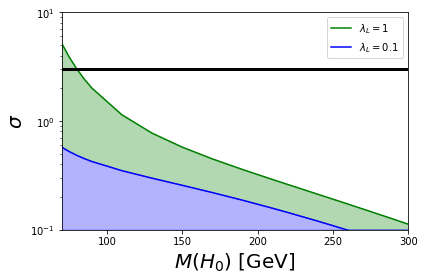

In [6]:
plot_fit(df,MHp=700,Lumi=30000,xmin=70,xmax=300,ymin=0.1,ymax=10,LaL1=1,LaL2=0.1,sigma=3,dots=False,
         pw1=3,pw2=3,ylabel=r'$\sigma$')

File: Signif_MHp_700_Lum_3000.pdf created


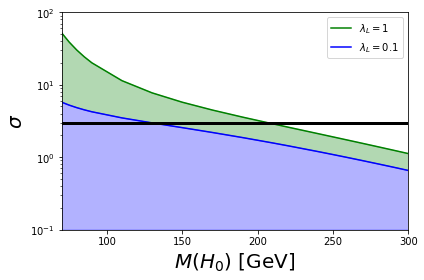

In [7]:
plot_fit(df,MHp=700,Lumi=3000000,xmin=70,xmax=300,ymin=0.1,ymax=100,LaL1=1,LaL2=0.1,sigma=3,dots=False,
         pw1=3,pw2=3,ylabel=r'$\sigma$')

### Figure 9

In [8]:
excl=3
df['MH0_excl']=0
df['Sgnf_excl']=excl

In [9]:
MHp=700;LaL1=10;crossing_plot=False

for LaL1 in np.sort(df.LaL.unique())[::-1]:
    print(LaL1)
    for Lumi in Lumis: #Lumis:    
        dffix=df[ np.logical_and( np.logical_and(df.MHp==MHp,df.Luminosity==Lumi),\
                  df.LaL==LaL1              )]
        df_match=dffix.index.values
        #print(Lumi,df_match[0])
        
        dffix=dffix.reset_index(drop=True)
        
        if not dffix.shape[0]:
            sys.exit('LaL=%g not found in data' %LaL1)
            
            
        cf=curvefit(dffix.MH0[0],dffix.Significance[0])
        cf.add_fit(2,ShowPlot=False)


        x = np.arange(dffix.MH0[0][0]-50,dffix.MH0[0][-1]+300, 0.05)
        #find the crossing between a curve cf(x) and a straight linx g(x)
        idx = np.argwhere(np.diff(np.sign (cf(x) - g(x,excl=excl) )) != 0).reshape(-1) + 0#
        excl_d={'M':0,'Sgnf':excl}
        if idx.shape[0]:
            excl_d={'M':x[idx[-1]],'Sgnf':cf(x)[idx[-1]]}
            if df_match.shape[0]:
                df.loc[df_match[0],'MH0_excl']=excl_d['M']
                df.loc[df_match[0],'Sgnf_excl']=excl_d['Sgnf']


        if crossing_plot:
            #dffix['MH0_excl']=excl['M']
            plt.semilogy(x,cf(x))
            plt.semilogy(x,g(x))
            plt.plot(excl_d['M'],excl_d['Sgnf'] , 'ro')

10.0
7.0
5.0
3.0
1.0
0.6
0.55
0.5
0.45
0.4
0.35
0.3
0.25
0.2
0.15
0.1
0.07
0.05
0.02
0.01


In [10]:
mpl.style.use('classic')

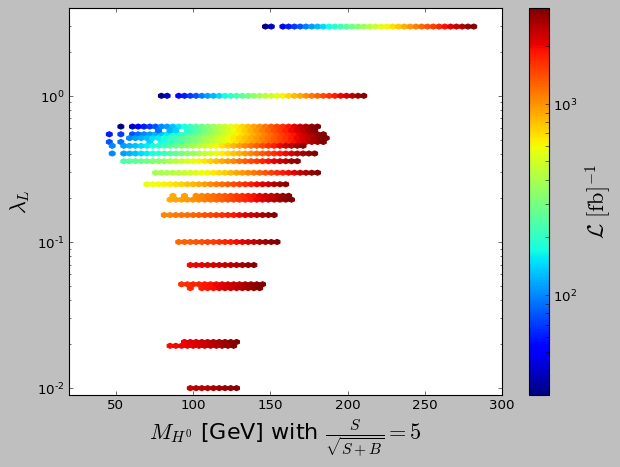

In [11]:
df=df[df.MH0_excl>0]
plt.hexbin(df.MH0_excl,df.LaL,df.Luminosity/1000.,yscale='log',norm=LogNorm())
ax=plt.colorbar()#ticks=[30,100,300,500,700,1000,3000])
#ax.set_ticklabels([30,100,300,1000,3000])
ax.set_label(r'${\cal L}\ [{\rm fb}]^{-1}$',size=20)
plt.xlim(20,300)
plt.ylim(9E-3,4)
plt.xlabel(r'$M_{H^0}$ [GeV] with $\frac{S}{\sqrt{S+B}}=5$',size=20)
plt.ylabel(r'$\lambda_L$',size=20)
plt.tight_layout()
plt.savefig('lc.pdf')
#plt.fill_between(xlf,lf(xlf),0.01,alpha=0.3,facecolor='m')
#plt.plot(lower.MH0_excl,lower.LaL,'ko')

In [12]:
maxLaL=0.55
dfl=df[df.LaL<maxLaL]
mf=[];lf=[]
for l in np.sort(dfl.LaL.unique())[::-1]:
    xx,yy=dfl[dfl.LaL==l].MH0_excl.min(),l
    mf.append(xx);lf.append(yy)

df_full=df.copy()
dfm=pd.DataFrame()
for L in [30000.,100000.,300000,1000000.,3000000.]:
    dfm=dfm.append(df_full[df_full.Luminosity==L],ignore_index=True)

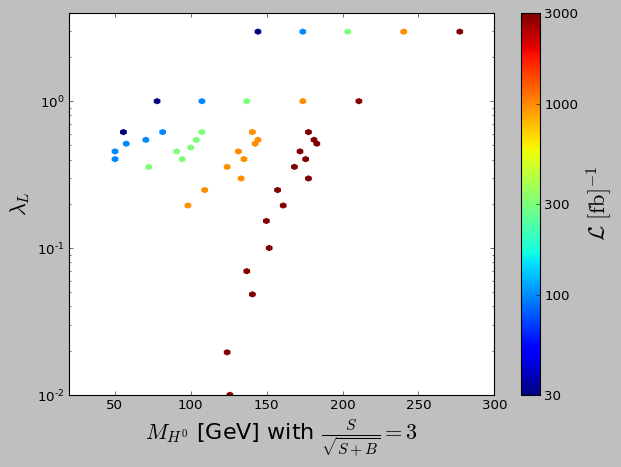

In [13]:
dfm=dfm[dfm.MH0_excl>0]
plt.hexbin(dfm.MH0_excl,dfm.LaL,dfm.Luminosity/1000.,yscale='log',norm=LogNorm())
ax=plt.colorbar(ticks=[30,100,300,1000,3000])
ax.set_ticklabels([30,100,300,1000,3000])
ax.set_label(r'${\cal L}\ [{\rm fb}]^{-1}$',size=20)
plt.xlim(20,300)
plt.ylim(1E-2,4)
plt.xlabel(r'$M_{H^0}$ [GeV] with $\frac{S}{\sqrt{S+B}}=3$',size=20)
plt.ylabel(r'$\lambda_L$',size=20)
plt.tight_layout()
plt.savefig('lc.pdf')

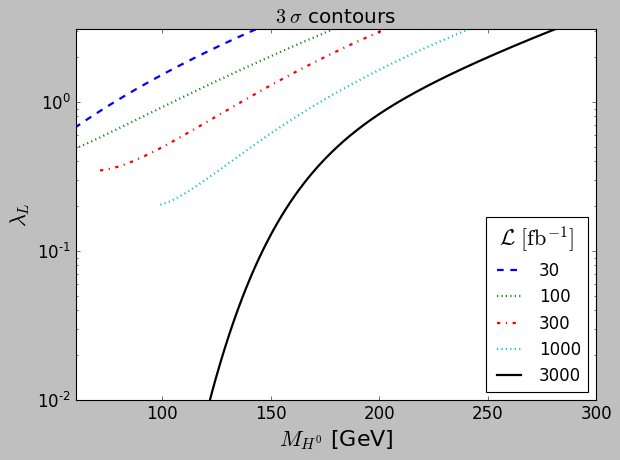

In [14]:
Dots=False
Lumis=[30000.,100000.,300000,1000000.,3000000.]
plt.rcParams.update({'font.size': 15})
line_format=['b--','g:','r-.','c:','k-']
i=0
for Lumi in Lumis:
    sd=df[df.Luminosity==Lumi]
    sf=curvefit(sd.MH0_excl,sd.LaL)
    #Special cases
    pw=5
    fix_beg=0
    if Lumi==30000:
        pw=2
        fix_beg=10
    if  Lumi==100000:
        fix_beg=0
        pw=2
    if  Lumi==300000:
        fix_beg=0
        pw=3        
    if Lumi==3000000:
        pw=6
        fix_beg=10

    #if Lumi==300000:
    #    pw=3        
    sf.add_fit(pw,ShowPlot=False)
    x=np.arange(sd.MH0_excl.min()-fix_beg,sd.MH0_excl.max())
    plt.semilogy( x, sf(x),line_format[i],label='%d' %int(Lumi/1000) ,lw=2 ) 
    if Dots:
        plt.semilogy( sd.MH0_excl, sd.LaL,'r*' ) 
    i=i+1

if Dots:
    plt.hexbin(dfm.MH0_excl,dfm.LaL,dfm.Luminosity/1000.,yscale='log',norm=LogNorm())
    

xlf=np.arange(mf[0],mf[-1]+15)
#plt.fill_between(xlf,lf(xlf),0.01,alpha=0.3,facecolor='m',lw=0)
leg=plt.legend(loc='lower right',prop={'size':15})
leg.set_title(r'${\cal L}\ [{\rm fb}^{-1}]$',prop={'size':20})
plt.xlim(60,300)
plt.ylim(1.E-2,3.1)    
plt.title('$3\;\sigma$ contours' )
plt.xlabel(r'$M_{H^0}$ [GeV]',size=20)
plt.ylabel(r'$\lambda_L$',size=20)
plt.tight_layout()
plt.savefig('lcf.pdf')

### Figures 7 (b) y 8 (b)

#### Full data with full luminosities for $M_{H^\pm}=250$ GeV

In [15]:
MHp=250 #MH+

df250=pd.DataFrame()
Lumis=[30000.,100000.,300000.,3000000.]
LaL=np.array([0.01,0.1,0.5,1.0,5.0,10.0])
MH0=np.array([70,75,80,85,90,110,130,150,190,210,220,240])
XS=np.array([[0.0349202532,0.0334004548,0.0317959539,0.0299136009,0.0284446578,0.0231171019,0.0182469057,0.0145908085,0.0032957252,0.0008311599,0.0002327398,2.69170669596E-005],[0.0401153803,0.0365328119,0.0339879003,0.0318100305,0.0299869285,0.0236790908,0.018614465,0.0148075782,0.0033628365,0.0008528258,0.0002575083,3.76243302046E-005],[0.1292954556,0.0877346517,0.0671422842,0.055387881,0.0473004018,0.0303751277,0.0220217644,0.0166179432,0.003983908,0.0012414054,0.0005508421,0.000212817],[0.3925881269,0.235609451,0.163829771,0.1215055018,0.0961519127,0.0487745888,0.0302338164,0.0211453691,0.0056017643,0.002215103,0.0013337227,0.0007131346],[8.8106015968,4.9330438839,3.2202837071,2.2445297762,1.6530410394,0.6298478626,0.2986637424,0.1646727753,0.0551913027,0.0339149853,0.0267049906,0.0175325777],[37.5523833824,21.5683403078,14.1510102501,10.1290781829,7.4208955246,2.883369972,1.3888054495,0.750051374,0.260519149,0.1647700939,0.1322070255,0.0871119659]])
Eff=np.array([[0.10438413361169102, 0.5230125523012552, 1.142263759086189, 1.3555787278415015, 1.4462809917355373, 1.2461059190031152], [0.2066115702479339, 0.625, 0.9394572025052192, 1.3499480789200415, 2.2821576763485476, 0.8359456635318704], [0.2070393374741201, 0.4175365344467641, 1.2396694214876034, 0.9297520661157025, 1.6684045881126173, 1.9771071800208118], [0.10471204188481675, 0.1037344398340249, 1.5723270440251573, 1.2474012474012475, 1.6528925619834711, 1.037344398340249], [0.0, 0.10482180293501048, 0.8221993833504625, 1.4598540145985401, 0.82389289392379, 1.435897435897436], [0.20639834881320948, 0.31088082901554404, 1.1387163561076605, 1.45681581685744, 1.3347022587268993, 0.8264462809917356], [0.20639834881320948, 0.30991735537190085, 0.6211180124223602, 1.5321756894790604, 2.5693730729701953, 1.0245901639344261], [0.2074688796680498, 0.10330578512396695, 0.8171603677221655, 1.2539184952978057, 1.6494845360824741, 1.7329255861365953], [0.0, 0.1180637544273908, 0.7821229050279329, 2.549889135254989, 2.378490175801448, 2.443991853360489], [0.684931506849315, 0.2604166666666667, 1.7921146953405018, 2.137232845894263, 2.6859504132231407, 3.8578680203045685], [1.0810810810810811, 1.4397905759162304, 3.939745075318656, 2.912621359223301, 3.615702479338843, 2.032520325203252], [3.814432989690722, 4.732510288065844, 3.6923076923076925, 2.3613963039014374, 2.5510204081632653, 2.443991853360489]])

for Lumi in Lumis:
    Significance=significance(XS,Eff,Lumi,TB)
    for i in range(LaL.shape[0]):
        df250=df250.append({'MHp':MHp,'Luminosity':Lumi,'LaL':LaL[i],'MH0':MH0,'XS':XS[i],'Eff':Eff.transpose()[i],\
                      'Significance':Significance.transpose()[i]},ignore_index=True)                 

File: Signif_MHp_250_Lum_30.pdf created


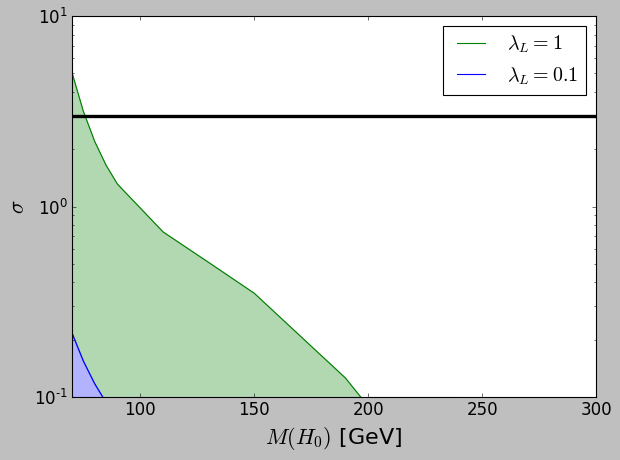

In [16]:
plot_fit(df250,MHp=250,Lumi=30000,xmin=70,xmax=300,ymin=0.1,ymax=10,LaL1=1,LaL2=0.1,sigma=3,dots=False,
         pw1=3,pw2=3,ylabel=r'$\sigma$')

File: Signif_MHp_250_Lum_3000.pdf created


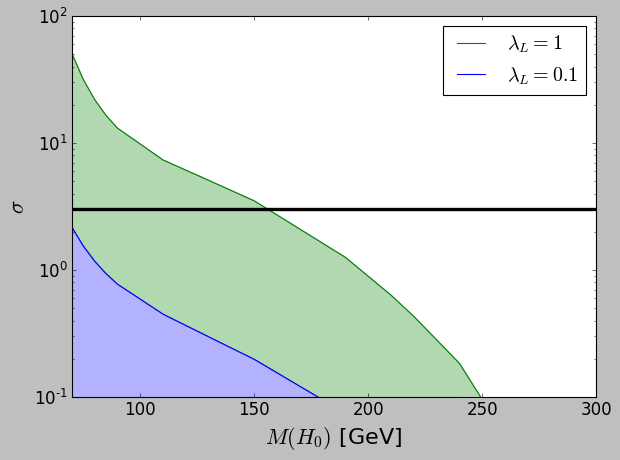

In [17]:
plot_fit(df250,MHp=250,Lumi=3000000,xmin=70,xmax=300,ymin=0.1,ymax=100,LaL1=1,LaL2=0.1,sigma=3,dots=False,
         pw1=3,pw2=3,ylabel=r'$\sigma$')

## Backup plots

(0.01, 1)

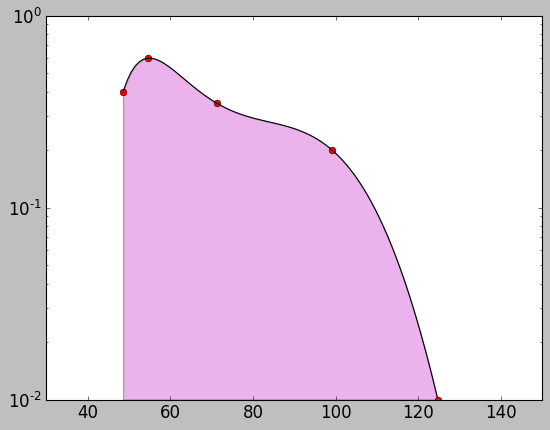

In [36]:
plt.rcParams.update({'font.size': 15})
lower=pd.DataFrame()
store_lower=True
points=False
i=0
for Lumi in Lumis:
    sd=df[df.Luminosity==Lumi]
    x=np.arange(sd.MH0_excl.min(),sd.MH0_excl.max())
    if store_lower:
        ymin=sd.LaL.min()
        get_point=sd[sd.LaL==ymin]
        if get_point.shape[0]==1:
            lower=lower.append(get_point[['MH0_excl','LaL']],ignore_index=True)
  
    if ymin==df.LaL.min():
        store_lower=False    
    
    i=i+1

    

plt.plot(lower.MH0_excl,lower.LaL,'ro')
lf=curvefit(lower.MH0_excl,lower.LaL)
lf.add_fit(4,ShowPlot=False)
xlf=np.arange( lower.MH0_excl.min(),lower.MH0_excl.max()  )
plt.semilogy(xlf,lf(xlf),'k-')
plt.fill_between(xlf,lf(xlf),0.01,alpha=0.3,facecolor='m')
#leg=plt.legend(loc='lower right',prop={'size':15})
#leg.set_title(r'${\cal L}\ [{\rm fb}^{-1}]$',prop={'size':20})
plt.xlim(30,150)
plt.ylim(1.E-2,1)    

File: Signif_dots_MHp_250_Lum_30.pdf created


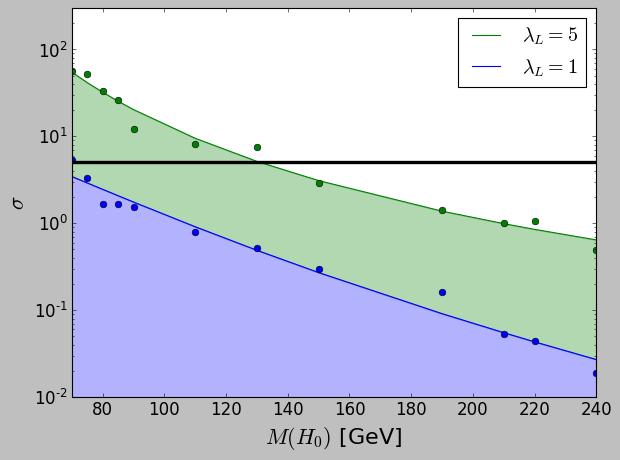

In [39]:
plot_fit(df250,MHp=250,Lumi=30000,ymin=0.01,ymax=300,LaL1=5,LaL2=1,dots=True)

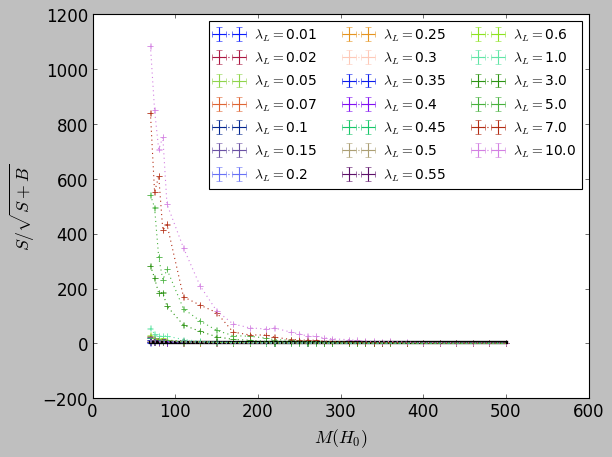

In [41]:
Uncertainty=np.sqrt(0.1**2+(np.sqrt(30)/30)**2) #Uncertainty from 8 TeV analysis + statistical uncertainty from MC samples
fig = plt.figure()
ax = fig.add_subplot(111)
for i in xrange(len(LaL)):
    ax.errorbar(MH0,Significance.transpose()[i], xerr=0.1, yerr=Uncertainty, linestyle='dotted', 
                label='$\lambda_{L}=$'+str(LaL[i]), color=np.random.rand(3,1))
#ax.errorbar(MH0,Significance.transpose()[0], xerr=0.1, yerr=Uncertainty, linestyle='dotted', label='$\lambda_{L}=0.01$')
#ax.errorbar(MH0,Significance.transpose()[-1], xerr=0.1, yerr=Uncertainty, linestyle='dotted', label='$\lambda_{L}=10.0$')
#ax.plot(MH0,Significance.transpose()[0],color="red",linestyle='solid')
#ax.plot(MH0,Significance.transpose()[5],color="blue",linestyle='solid')
#ax.plot(MH0,Significance.transpose()[10],color="green",linestyle='solid')
#ax.plot(MH0,Significance.transpose()[15],color="yellow",linestyle='solid')
#ax.plot(MH0,Significance.transpose()[18],color="magenta",linestyle='solid')
#ax.plot(MH0,Significance.transpose()[-1],color="black",linestyle='solid')
ax.plot((MH0[0],MH0[-1]),(5.0,5.0),linewidth=3,color="black",linestyle='solid')
#ax.axhline(y=10.0, xmin=MH0[0], xmax=MH0[-1], linewidth=10, color = 'k')
#ax.set_yscale('log')
ax.set_ylabel(r'$S/\sqrt{S+B}$', fontsize=16)
ax.set_xlabel(r'$M(H_{0})$', fontsize=16)
legend = ax.legend(loc='upper right', shadow=False, fontsize='small', ncol=3)
plt.show()